In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.io.votable import parse
import scipy.optimize as opt
from scipy.stats import gaussian_kde

**ADQL Queries**

**RA/Dec/radius based on data from SIMBAD**

M44: CIRCLE('ICRS',130.1, 19.666666667, 1.0) 2.0, where second radius outside the parens was the actual one used in final version

M67: CIRCLE('ICRS',132.825, 11.817, 0.5)) 1.0

NGC 188: CIRCLE('ICRS',12.108325, 85.255, 0.25) 0.5

NGC 6791: CIRCLE('ICRS',290.22075, 37.7716666667, 0.25) 0.5

M71: CIRCLE('ICRS',298.443708333, 18.7791944444, 0.2) 0.4

### Read and concatenate data

In [2]:
def read_data(filepath):
    votable = parse(filepath)
    table = votable.get_first_table().to_table(use_names_over_ids=True).to_pandas()
    return table

In [3]:
m44 = read_data("gaia-project/data/m44-result3.vot")
#m44 = pd.read_csv("gaia-project/data/M44_data.csv")
m67 = read_data("gaia-project/data/m67-result.vot")
ngc188 = read_data("gaia-project/data/ngc188-result.vot")
ngc6791 = read_data("gaia-project/data/ngc6791-result.vot")
m71 = read_data("gaia-project/data/m71-result.vot")

In [4]:
m44['tag'] = 'm44'
m67['tag'] = 'm67'
ngc188['tag'] = 'ngc188'
ngc6791['tag'] = 'ngc6791'
m71['tag'] = 'm71'
df = pd.concat([m44, m67, ngc188, ngc6791, m71])

In [5]:
df.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,tag
0,658641927856681600,130.538408,17.982766,NaN,NaN,NaN,NaN,NaN,NaN,20.723475,21.098349,19.648428,m44
1,658645295110335744,130.874910,18.031599,0.990987,0.954524,1.911176,1.775310,-11.619265,1.361311,20.215315,20.466936,19.408482,m44
2,658606331166850560,130.303256,17.693717,-0.246051,0.328922,-0.420053,0.551464,1.138094,0.367538,18.987206,19.655430,18.114813,m44
3,658650827029291904,130.723324,18.156532,NaN,NaN,NaN,NaN,NaN,NaN,21.054741,NaN,NaN,m44
4,658629764508516864,130.863103,17.858004,-0.718893,0.481921,-0.877231,0.914352,-3.587620,0.627439,19.239706,19.482729,18.727898,m44


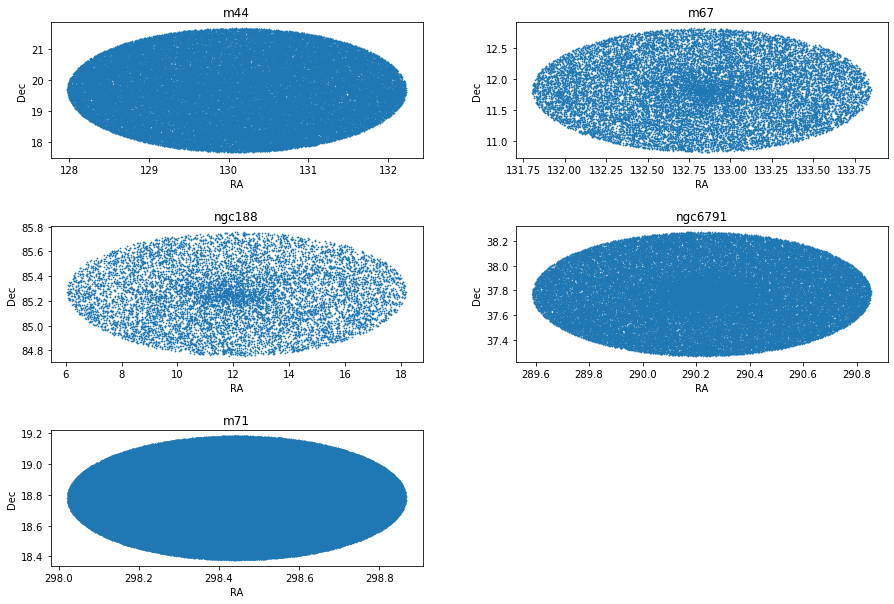

In [6]:
def plot_ra_dec(df, tag, ax):
    ax.scatter(df.loc[df.tag==tag].ra,
               df.loc[df.tag==tag].dec, 
               s=0.5)
    ax.set_title(tag)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

    return

tags = ["m44", "m67", "ngc188", "ngc6791", "m71"]
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=0.5)
axes = axes.flatten()
for i in range(len(tags)):
    ax = axes[i]
    plot_ra_dec(df, tags[i], ax)

fig.delaxes(axes[5]) 
plt.show()

### Convert photometry

In [7]:
def convert_to_v(g, gr, gb):
    """
    Uses polynomial relation from Johnson-Cousins Table 5.8 referenced in instructions to get V band
    g: G-band
    gr: G-band Red Photometry
    gb: G-band Blue Photometry
    """
    diff = gb - gr
    poly = -0.01760 - 0.006860 * diff - 0.1732 * diff**2
    return g - poly

def convert_to_i(g, gr, gb):
    """
    Uses polynomial relation from Johnson-Cousins Table 5.8 referenced in instructions to get I band
    g: G-band
    gr: G-band Red Photometry
    gb: G-band Blue Photometry
    """
    diff = gb - gr
    poly = 0.02085 + 0.7419 * diff - 0.09631 * diff**2
    return g - poly

df['vband'] = convert_to_v(df.phot_g_mean_mag, df.phot_rp_mean_mag, df.phot_bp_mean_mag)
df['iband'] = convert_to_i(df.phot_g_mean_mag, df.phot_rp_mean_mag, df.phot_bp_mean_mag)

### Plot Color Magnitude Diagrams

In [8]:
# 4. for each cluster, plot CMD for V vs V-I
#fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
#fig.set_size_inches(15, 10)
#plt.subplots_adjust(wspace=0.5, hspace=0.5)
#axes = axes.flatten()

"""
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
"""

def plot_v_vi(df, tag, ax):
    ax.scatter(df.loc[df.tag==tag].vband - df.loc[df.tag==tag].iband,
               df.loc[df.tag==tag].vband, 
               s=0.5)
    ax.set_title(tag, fontsize=18)
    ax.set_xlabel('V-I mag', fontsize=16)
    ax.set_ylabel('V mag', fontsize=16)
    ax.set_ylim(ax.get_ylim()[::-1]) # invert y-axis so brightest is top

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return

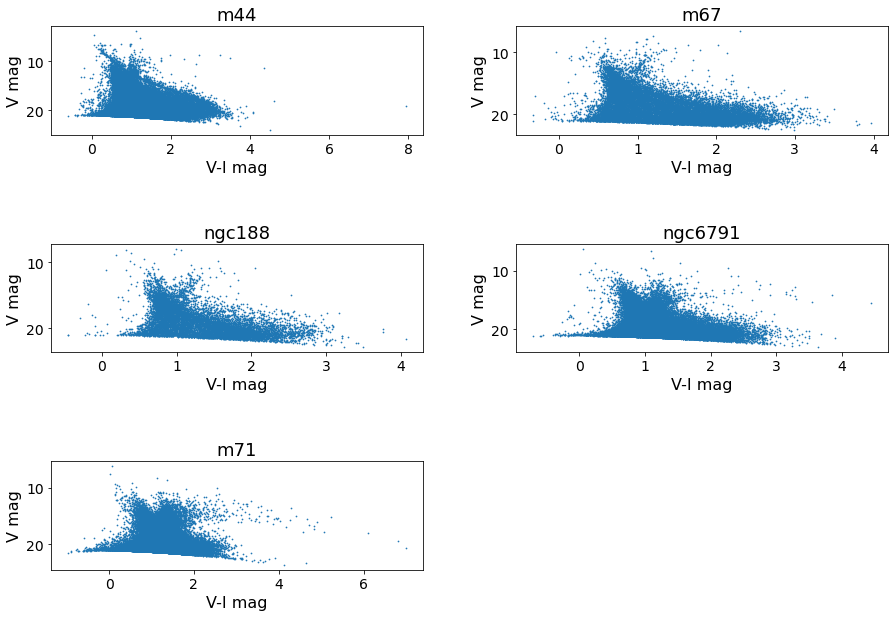

In [9]:
tags = ["m44", "m67", "ngc188", "ngc6791", "m71"]
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for i in range(len(tags)):
    ax = axes[i]
    plot_v_vi(df, tags[i], ax)

fig.delaxes(axes[5]) 
#fig.tight_layout()
fig.savefig('v_vi_cmd.png')
plt.show()


#### Kick out impostors using proper motion

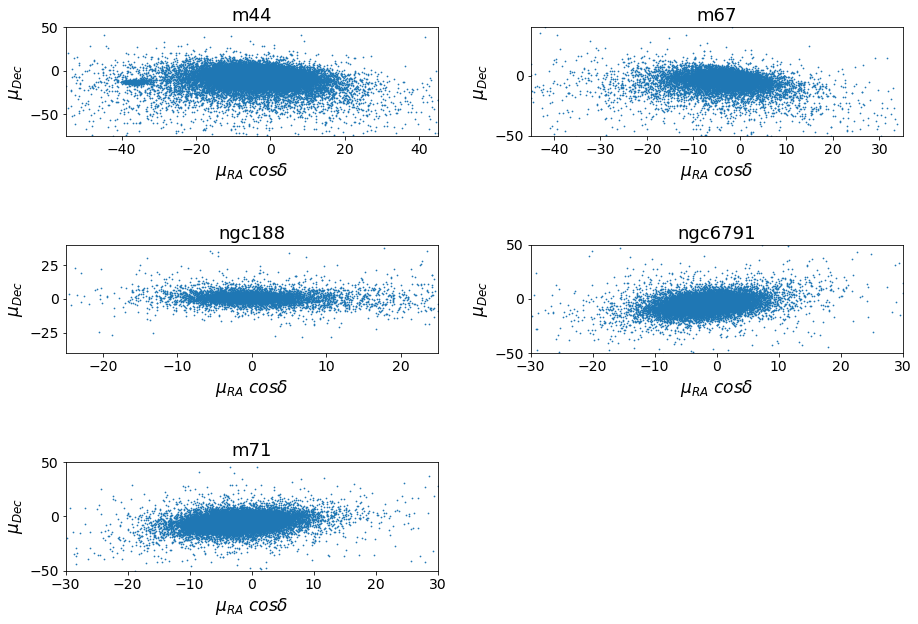

In [10]:
# 5. for each cluster, plot proper motion diagram
def plot_proper_motion(df, tag, ax):
    ax.scatter(df.loc[df.tag==tag].pmra, df.loc[df.tag==tag].pmdec, s=0.5)
    ax.set_title(tag, fontsize=18)
    #ax.set_ylabel('Dec proper motion', fontsize=16)
    ax.set_ylabel(r'$\mu_{Dec}$', fontsize=17)
    ax.set_xlabel(r'$\mu_{RA}$ $cos\delta$', fontsize=17)
    if tag=='m44':
        ax.set_xlim([-55, 45])
        ax.set_ylim([-75, 50])
    elif tag=='m67':
        ax.set_xlim([-45, 35])
        ax.set_ylim([-50, 40])
    elif tag=='ngc188':
        ax.set_xlim([-25, 25])
        ax.set_ylim([-40, 40])
    elif tag=='ngc6791':
        ax.set_xlim([-30, 30])
        ax.set_ylim([-50, 50])
    elif tag=='m71':
        ax.set_xlim([-30, 30])
        ax.set_ylim([-50, 50])
    
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for i in range(len(tags)):
    ax = axes[i]
    plot_proper_motion(df, tags[i], ax)

fig.delaxes(axes[5]) 
fig.savefig('proper_motion.png')
plt.show()


m44  radius:  100.73045058452695
before:  67194
after:  1430
67310 1430
avg parallax:  5.307113011213582
m67  radius:  39.219860493943244
before:  19133
after:  3296
19435 3296
avg parallax:  1.1266197623625605
ngc188  radius:  28.893159612750843
10200 9998
avg parallax:  0.6015910488972052
ngc6791  radius:  17.660670129349597
56936 55915
avg parallax:  0.3162420394850522
m71  radius:  12.396694749301746
176916 173374
avg parallax:  0.2396670352562688


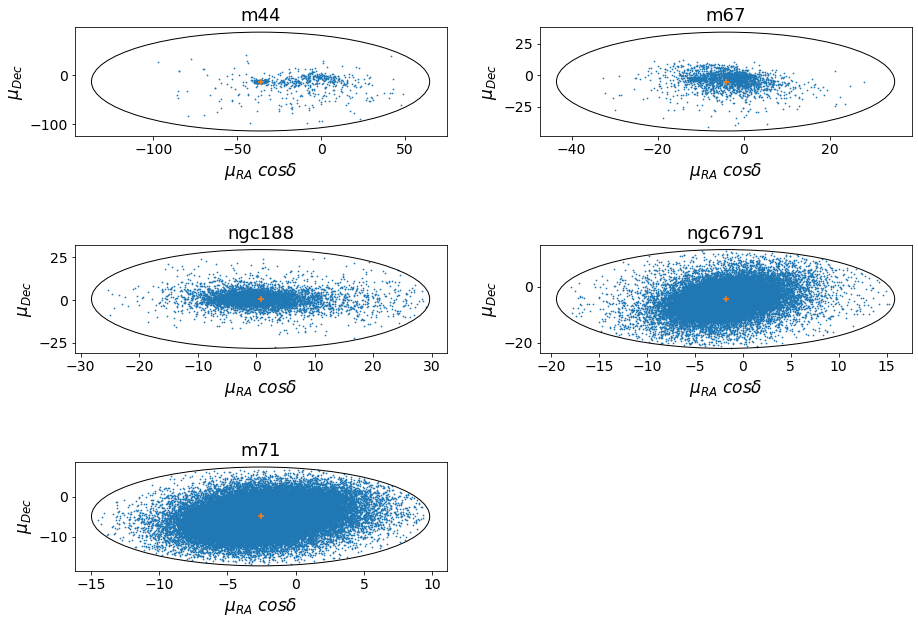

244013
              source_id          ra        dec  parallax  parallax_error  \
91   658612653359396736  130.405647  17.750190  5.107567        1.807697   
214  658606266742061568  130.308107  17.681197  4.794474        0.643534   
260  658614444360886272  130.415787  17.787800  4.898005        0.095407   
423  658615440793299712  130.358808  17.803475  5.525518        0.102051   
472  658641996575437440  130.572943  17.987457  5.434267        0.128190   

          pmra  pmra_error      pmdec  pmdec_error  phot_g_mean_mag  \
91   -7.496875    2.758896 -13.169736     1.739721        20.657295   
214 -45.620671    0.964570 -22.317537     0.577844        19.541794   
260   3.285120    0.154360  16.269269     0.086077        16.470478   
423 -37.240774    0.159946 -11.772343     0.091903        16.564083   
472 -36.457993    0.190665 -11.585539     0.097979        16.675661   

     phot_bp_mean_mag  phot_rp_mean_mag  tag      vband      iband  
91          20.965080         19.214186 

In [96]:
# 6. for each cluster, find center and radius of proper motion distribution
def calculate_std(centerx, centery, x, y):
    dist = (y-centery)**2 + (x-centerx)**2
    return np.sqrt(np.sum(dist)/len(dist))
    
def proper_motion_plot_n_triage(tag, ax):
    x = df.loc[df.tag==tag].pmra
    xerr = df.loc[df.tag==tag].pmra_error
    y = df.loc[df.tag==tag].pmdec
    yerr = df.loc[df.tag==tag].pmdec_error

    # calculate center and std to optimal radius
    if tag=='m44': # for some reason, taking 
        centerx = -36.047
        centery = -12.917
    else:
        centerx = np.mean(df.loc[df.tag==tag].pmra)
        centery = np.mean(df.loc[df.tag==tag].pmdec)
    
    #centerx = np.mean(df.loc[df.tag==tag].pmra)
    #centery = np.mean(df.loc[df.tag==tag].pmdec)
        
    std = calculate_std(centerx, centery, x, y)
    print(tag, " radius: ", 3*std)
    circle = plt.Circle((centerx, centery), 3*std, fill=False)

    # kick out points outside radius
    #mask = np.sqrt((x - centerx)**2 + (y - centery)**2) < 1.5*std
    num_of_sigs = 3.0
    
    #if tag=='m44':
    #    num_of_sigs = 3.
    #else:
    #    num_of_sigs = 3.
        
    mask = ((np.sqrt(((x-xerr) - centerx)**2 + ((y-yerr) - centery)**2)) >= num_of_sigs*std) | ((np.sqrt(((x+xerr) - centerx)**2 + ((y+yerr) - centery)**2)) >= num_of_sigs*std) | ((np.sqrt(((x-xerr) - centerx)**2 + ((y+yerr) - centery)**2)) >= num_of_sigs*std) | ((np.sqrt(((x+xerr) - centerx)**2 + ((y-yerr) - centery)**2)) >= num_of_sigs*std)
    keep = df.loc[df.tag==tag][~mask]
    
    #"""
    if tag=='m44':
        print("before: ", len(keep))
        keep = keep.loc[(keep.parallax >= 4.621) & (keep.parallax <= 6.121)] # +/- 0.75 mas
        print("after: ", len(keep))
    elif tag=='m67':
        print("before: ", len(keep))
        #keep = keep.loc[(keep.parallax >= 0.9325) & (keep.parallax <= 1.3325)] # +/- 0.2 mas
        keep = keep.loc[(keep.parallax >= 0.9325) & (keep.parallax <= 1.3325)] # +/- 0.2 mas
        print("after: ", len(keep))
    #"""
        
    print(len(df.loc[df.tag==tag]), len(keep))
    #within_palm = hand_contour[mask,:] 
    
    # plot survivors with circle
    ax.scatter(keep.pmra, keep.pmdec, s=0.5)
    print("avg parallax: ", np.mean(keep.parallax))
    ax.scatter(centerx, centery, marker='+')
    ax.add_patch(circle)

    ax.set_title(tag, fontsize=18)
    #ax.set_ylabel('Dec proper motion')
    #ax.set_xlabel('RA proper motion')
    ax.set_ylabel(r'$\mu_{Dec}$', fontsize=17)
    ax.set_xlabel(r'$\mu_{RA}$ $cos\delta$', fontsize=17)
    
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return keep

df_triaged = pd.DataFrame()
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()

for i in range(len(tags)):
    ax = axes[i]
    keep = proper_motion_plot_n_triage(tags[i], ax)
    df_triaged = pd.concat([df_triaged, keep])

fig.delaxes(axes[5]) 
fig.savefig('proper_motion_keep.png')
plt.show()

print(len(df_triaged))
print(df_triaged.head())


What about a 2D Gaussian KDE? 

In [13]:
temp = df.loc[df.tag == 'm44']

-810.2868354355569 339.1337528113895 -451.76900510078815 87.29845350246525
[[2.08554057e-07 8.76108213e-07 5.90164207e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.64150981e-09 9.91635356e-09 9.60586613e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.03477768e-15 1.76764439e-14 2.46234464e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


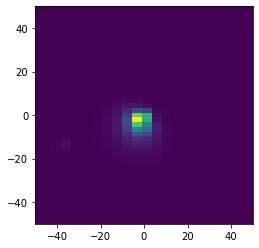

In [14]:
from scipy.stats import gaussian_kde
from scipy.ndimage import rotate

xaxis = temp.pmra
yaxis = temp.pmdec
xmin = xaxis.min()
#xmin = 10
xmax = xaxis.max()
ymin = yaxis.min()
#ymin = 3
ymax = yaxis.max()
#ymax = 6.1
X, Y = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
#X, Y = np.mgrid[0:15:100j, 0:10:100j]
print(xmin, xmax, ymin, ymax)

positions = np.vstack([X.ravel(), Y.ravel()]) # perform kernel density estimate on data

values = np.vstack([xaxis, yaxis])
#print(values, values[0].max(), values[1].max())
#print(np.nan_to_num(values, nan=5000)[1].max())
values = np.nan_to_num(values, nan=0)
kernel = gaussian_kde(values)

Z_jmag_age = np.reshape(kernel(positions).T, X.shape)
print(Z_jmag_age)

fig, ax = plt.subplots()
Z_jmag_age = rotate(Z_jmag_age, angle=90)
#ax.plot(xaxis, yaxis, 'k.', markersize=2) # data
ax.imshow(Z_jmag_age,
          extent=[xmin, xmax, ymin, ymax])
ax.set_xlim([-50, 50])
#plt.yscale('log')
ax.set_ylim([-50, 50])
plt.show()


Maybe another time :')

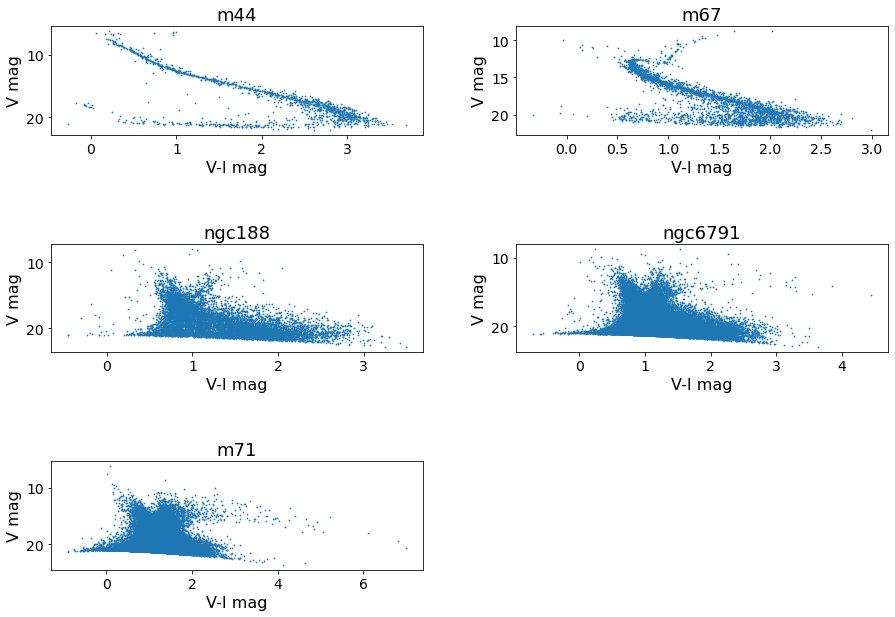

In [97]:
# 7. (V, V-I) CMD for survivors for each cluster
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for i in range(len(tags)):
    ax = axes[i]
    plot_v_vi(df_triaged, tags[i], ax)

fig.delaxes(axes[5]) 
fig.savefig('v_vi_keep_cmd.png')
plt.show()


In [52]:
print(len(df), len(df_triaged))

330797 244013


### Time for parallaxes

In [99]:
df_triaged['parallax_err1'] = df_triaged.parallax - df_triaged.parallax_error
df_triaged['parallax_err2'] = df_triaged.parallax + df_triaged.parallax_error
df_triaged = df_triaged.loc[df_triaged.parallax > 0.] # remove negative parallaxes

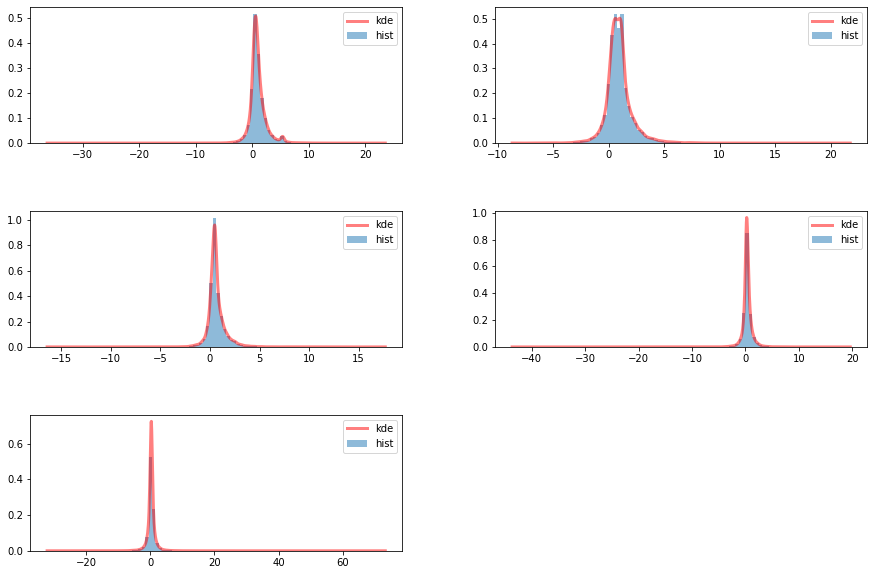

In [18]:
# 8a. for each cluster, make binned histogram of parallaxes
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram 
def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

nbins = 20
def plot_histograms_n_kde(data, ax):
    hist, bins = np.histogram(data, bins=1000)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model

    ax.hist(data, 100, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    ax.legend()
    
    return 
    
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=0.5)
axes = axes.flatten()
for tag in range(len(tags)):
    ax = axes[tag]
    plot_histograms_n_kde(df_triaged.loc[df_triaged.tag==tags[tag]].parallax, ax)

fig.delaxes(axes[5]) 
fig.savefig('parallax.png')
plt.show()

Meh. I don't as easily get mean and std out of this. Let's just do it the old-fashioned way.

5.307113011213582
0.32155151723084074
1430
1110
cluster:  m44
mean:  5.329242449198718 std:  0.18456682923577922 error:  0.004880739544311404
distance [pc]:  187.64393054595513
distance modulus:  6.366672607320519
1.1266197623625605
0.10256683080834804
3296
1687
cluster:  m67
mean:  1.1228181185102006 std:  -0.07443233373879223 error:  -0.0012964866061647095
distance [pc]:  890.6161946574566
distance modulus:  9.748452939639753
0.7611652618287212
0.6748228795677603
8014
7430
cluster:  ngc188
mean:  0.42560629287459445 std:  0.2878076717137578 error:  0.0032149757178935494
distance [pc]:  2349.5893193822008
distance modulus:  11.854959796651187
0.5799722373151702
0.6369282125319642
39550
36088
cluster:  ngc6791
mean:  0.19944047673670054 std:  -0.3483840148748282 error:  -0.0017518018307207076
distance [pc]:  5014.027324654818
distance modulus:  13.500933481890879
0.6987820339478279
1.0065703824806809
106039


<ipython-input-139-a156854ba67c>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_parallax['dist_mod_cluster'] = dist_mod
<ipython-input-139-a156854ba67c>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_parallax['dist_mod_cluster_err'] = dist_mod_error
<ipython-input-139-a156854ba67c>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

99220
cluster:  m71
mean:  0.1277839802327129 std:  0.4139002174538705 error:  0.0012710506083479182
distance [pc]:  7825.707089252166
distance modulus:  14.467617942649447


<ipython-input-139-a156854ba67c>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_parallax['dist_mod_cluster'] = dist_mod
<ipython-input-139-a156854ba67c>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_parallax['dist_mod_cluster_err'] = dist_mod_error
<ipython-input-139-a156854ba67c>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

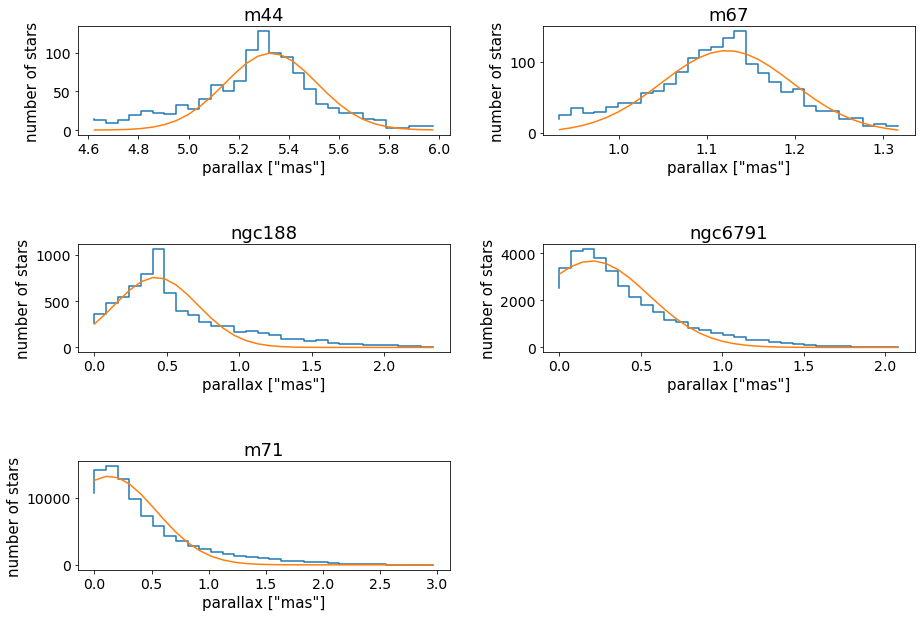

In [139]:
# 8a. for each cluster, make binned histogram of parallaxes
# 8b. turn binned histogram into generalized histogram via KDE
# 8c. calculate distance modulus
from scipy.optimize import curve_fit
def gauss(x, a, mu, sigma):
          return a*np.exp(-.5*(x-mu)**2/(sigma**2))

def plot_histograms(data, tag, ax):
    #############################################
    # Generic Gaussian fitting over histograms, plotting, cuts, and extinction
    # Input: cluster by cluster DataFrame, cluster name, matplotlib ax object
    # Output: triaged cluster DataFrame
    #############################################
    
    data_parallax = data.parallax
    
    # Get data params
    data_mean = np.mean(data_parallax)
    data_std = np.std(data_parallax)
    print(data_mean)
    print(data_std)
    
    # Triage
    print(len(data))
    num_sigma = 2.5
    keep_parallax = data.loc[~(np.abs((data.parallax+data.parallax_error)-data_mean) >= num_sigma*data_std) & ~(np.abs((data.parallax-data.parallax_error)-data_mean) >= num_sigma*data_std)]
    #mask = ((np.sqrt(((x-xerr) - centerx)**2 + ((y-yerr) - centery)**2)) < num_of_sigs*std) | ((np.sqrt(((x+xerr) - centerx)**2 + ((y+yerr) - centery)**2)) < num_of_sigs*std) | ((np.sqrt(((x-xerr) - centerx)**2 + ((y+yerr) - centery)**2)) < num_of_sigs*std) | ((np.sqrt(((x+xerr) - centerx)**2 + ((y-yerr) - centery)**2)) < num_of_sigs*std)
    print(len(keep_parallax))
    
    """
    if tag=='ngc188': # Investigate clusters with long tails
        keep_parallax = keep_parallax.loc[(keep_parallax.parallax <= 0.75) & (keep_parallax.parallax >= 0.3)]
    elif tag=='ngc6791':
        keep_parallax = keep_parallax.loc[(keep_parallax.parallax <= 0.4) & (keep_parallax.parallax >= 0.05)]
    elif tag=='m71':
        keep_parallax = keep_parallax.loc[(keep_parallax.parallax <= 0.4) & (keep_parallax.parallax <= 0.05)]
    else:
        pass
    
    if (tag=='m44') or (tag=='m67'): # Investigate clusters with multiple principal components
        hist, bins = np.histogram(data_parallax, bins=30)
    else:
        hist, bins = np.histogram(data_parallax, bins=30)
    """
    hist, bins = np.histogram(keep_parallax.parallax, bins=30)
    
    # Gaussian fit
    popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=hist, p0=[1,1,1])
    fit = gauss(bins[:-1], *popt)
    
    fit_mean = popt[1]
    fit_std = popt[2]
    fit_error = popt[2]/np.sqrt(len(data))
    distance = 1000./fit_mean
    distance_error = fit_error # everything cancels out
    dist_mod = 5*np.log10(distance) - 5
    dist_mod_error = 0.434*distance_error/distance
    print("cluster: ", tag)
    print("mean: ", fit_mean, "std: ", fit_std, "error: ", fit_error)
    print("distance [pc]: ", distance)
    print("distance modulus: ", dist_mod)
    keep_parallax['dist_mod_cluster'] = dist_mod
    keep_parallax['dist_mod_cluster_err'] = dist_mod_error
    keep_parallax['dist_mod_indiv'] = 5*np.log10(1000./keep_parallax.parallax) - 5
    #keep_parallax['dist_mod_indiv_err1'] = keep_parallax.dist_mod_indiv - (5*np.log10(1000./keep_parallax.parallax_error) - 5)
    #keep_parallax['dist_mod_indiv_err2'] = keep_parallax.dist_mod_indiv + (5*np.log10(1000./keep_parallax.parallax_error) - 5)
    
    # Plot
    ax.step(bins[:-1], hist)
    ax.plot(bins[:-1], fit)
    ax.set_ylabel('number of stars', fontsize=15)
    ax.set_xlabel('parallax ["mas"]', fontsize=15)
    ax.set_title(tag, fontsize=18)
    
    # Investigate long tails
    #if tag=='ngc6791':
    #    ax.set_xlim([0,5])
    #elif tag=='m71':
    #    ax.set_xlim([0,5])
    
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return keep_parallax
  
########################################################################################## 
# 9. for each star, use parallax and adopted reddening to convert V to Mv and (V-I) to (V-I)o
# Av = 2.5*E(V-I), with E(V-I) values taken from the following pieces of literature
# M44: 0.027 Brandt & Huang 2015 https://arxiv.org/pdf/1504.00004.pdf
# M67: 0.01 Chaboyer 1998; 0.050 +/- 0.013 from Sandquist 2004 https://academic.oup.com/mnras/article/347/1/101/1269478
# NGC 188: 0.114 +/- 0.013 Meibon 2009 https://iopscience.iop.org/article/10.1088/0004-6256/137/6/5086
# NGC 6791: 0.125 Chaboyer 1998 1.25*E(B-V) https://arxiv.org/pdf/astro-ph/9812097.pdf; or 0.195 +/- 0.003 Grundahl et al 2008 using E(V-I)=1.3*E(B-V) and latter of 0.15+/-0.02; https://arxiv.org/pdf/0810.2407.pdf
# M71: 0.19 Samra_2009; also McCormac et al 2014 https://core.ac.uk/download/pdf/111216779.pdf: E(B-V) = Av/3.1, where E(B-V) = 0.31
# so for M71, Av = 3.1*0.31, and E(V-I)=3.1*0.31/2.5=0.3844...which one to use?? 
##########################################################################################
evis = [0.027, 0.050, 0.114, 0.125, 0.19]
def calculate_mv(keep_parallax, evi):
    Av = 2.5*evi
    keep_parallax['Mv_indiv'] = keep_parallax.vband - keep_parallax.dist_mod_indiv - Av
    keep_parallax['Mv_cluster'] = keep_parallax.vband - keep_parallax.dist_mod_cluster - Av

    return keep_parallax

def calculate_mvi(keep_parallax, evi):
    Av = 2.5*evi
    keep_parallax['(V-I)o_indiv'] = keep_parallax.vband - keep_parallax.iband - keep_parallax.dist_mod_indiv - Av
    keep_parallax['(V-I)o_cluster'] = keep_parallax.vband - keep_parallax.iband - keep_parallax.dist_mod_cluster - Av

    return keep_parallax

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
keep_parallaxes = pd.DataFrame()
for tag in range(len(tags)):
    ax = axes[tag]
    keep_parallax = plot_histograms(df_triaged.loc[df_triaged.tag==tags[tag]], tags[tag], ax)
    keep_parallax = calculate_mv(keep_parallax, evis[tag])
    keep_parallax = calculate_mvi(keep_parallax, evis[tag])
    keep_parallaxes = pd.concat([keep_parallaxes, keep_parallax])
    
fig.delaxes(axes[5]) 
fig.savefig('parallax.png')
plt.show()


In [140]:
print(len(df_triaged))
print(len(keep_parallaxes))

158329
145535


In [146]:
keep_parallaxes.loc[keep_parallaxes.tag=='m44']

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,...,iband,parallax_err1,parallax_err2,dist_mod_cluster,dist_mod_cluster_err,dist_mod_indiv,Mv_indiv,Mv_cluster,(V-I)o_indiv,(V-I)o_cluster
260,658614444360886272,130.415787,17.787800,4.898005,0.095407,3.285120,0.154360,16.269269,0.086077,16.470478,...,15.141956,4.802598,4.993412,6.366673,0.000011,6.549904,11.180568,11.363799,-3.961388,-3.778157
423,658615440793299712,130.358808,17.803475,5.525518,0.102051,-37.240774,0.159946,-11.772343,0.091903,16.564083,...,15.224143,5.423466,5.627569,6.366673,0.000011,6.288135,11.588062,11.509524,-3.636081,-3.714619
472,658641996575437440,130.572943,17.987457,5.434267,0.128190,-36.457993,0.190665,-11.585539,0.097979,16.675661,...,15.332722,5.306076,5.562457,6.366673,0.000011,6.324295,11.677791,11.635413,-3.654931,-3.697309
486,658641481178824576,130.645168,17.991012,5.592770,0.315270,-35.074809,0.329246,-5.400269,0.236133,10.558574,...,9.961537,5.277499,5.908040,6.366673,0.000011,6.261865,4.385829,4.281022,-5.575708,-5.680515
655,658646948673404672,130.879971,18.110639,4.633490,0.038968,-17.374466,0.058756,-5.249938,0.033425,13.628607,...,12.611706,4.594522,4.672458,6.366673,0.000011,6.670459,7.439690,7.743476,-5.172016,-4.868230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66897,665134788832485120,130.288115,21.595224,4.987160,0.075021,40.561871,0.129738,-47.147540,0.081076,16.502081,...,15.276761,4.912139,5.062180,6.366673,0.000011,6.510734,10.894116,11.038177,-4.382646,-4.238584
67006,664916570133718272,130.513513,21.172577,5.501254,0.220935,-36.413020,0.335470,-13.422570,0.206011,18.166424,...,16.768515,5.280319,5.722189,6.366673,0.000011,6.297691,13.525088,13.456107,-3.243426,-3.312407
67091,664922102051593472,130.399231,21.293563,5.610671,0.148089,-37.851722,0.221016,-14.848378,0.135492,17.356438,...,15.996554,5.462582,5.758760,6.366673,0.000011,6.254926,12.514400,12.402654,-3.482154,-3.593901
67135,665129291274350976,130.150810,21.561657,5.359579,0.054919,-36.082837,0.082038,-13.671209,0.049834,11.539830,...,10.912261,5.304660,5.414498,6.366673,0.000011,6.354347,5.291794,5.279468,-5.620467,-5.632793


1110
1687
7430
36088
99220


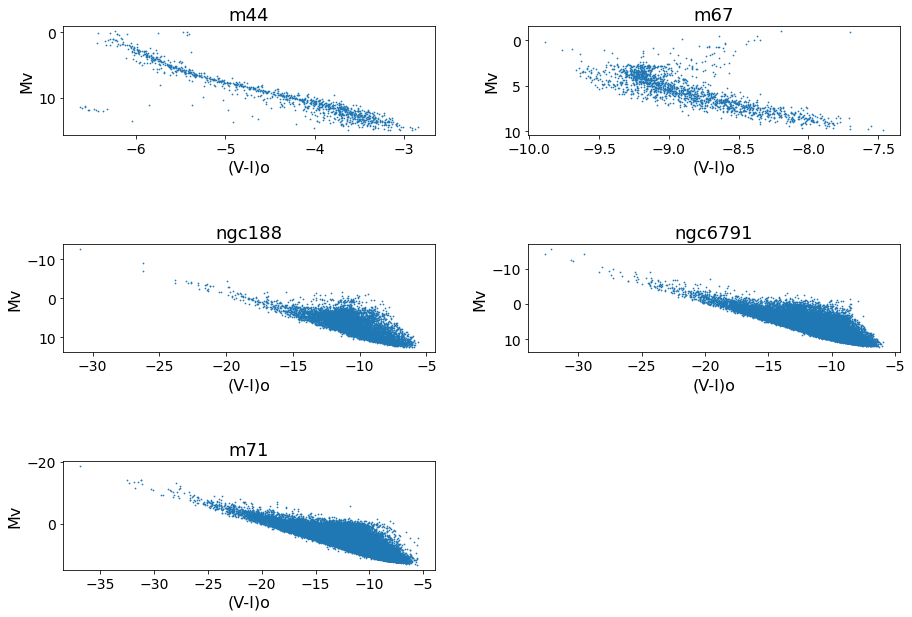

In [137]:
# 9. (Mv, [V-I]o) distance- and reddening-corrected CMD
def plot_mv_vio(df, tag, ax, xaxis, yaxis):
    print(len(df.loc[df.tag==tag]))
    ax.scatter(df.loc[df.tag==tag][xaxis],
               df.loc[df.tag==tag][yaxis], 
               s=0.5)
    ax.set_title(tag, fontsize=18)
    ax.set_xlabel('(V-I)o', fontsize=16)
    ax.set_ylabel('Mv', fontsize=16)
    ax.set_ylim(ax.get_ylim()[::-1]) # invert y-axis so brightest is top

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for i in range(len(tags)):
    ax = axes[i]
    plot_mv_vio(keep_parallaxes, tags[i], ax, '(V-I)o_indiv', 'Mv_indiv')

fig.delaxes(axes[5]) 
fig.savefig('mv_vio_indiv_keep_cmd.png')
plt.show()


1110
1687
7430
36088
99220


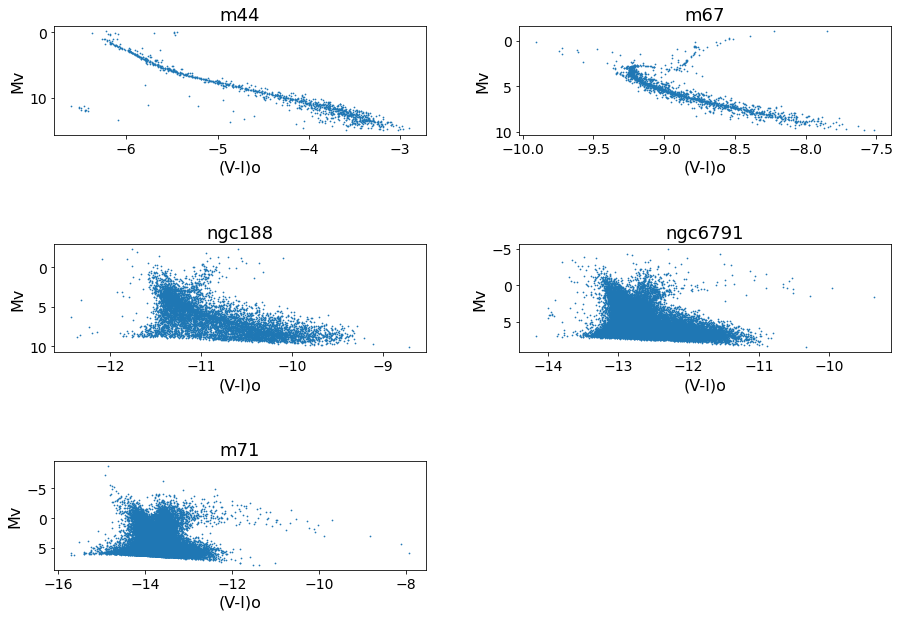

In [147]:
# 10. (Mv, [V-I]o) distance- and reddening-corrected CMD, using cluster parallaxes rather than individual stars'
def plot_mv_vio(df, tag, ax, xaxis, yaxis):
    print(len(df.loc[df.tag==tag]))
    ax.scatter(df.loc[df.tag==tag][xaxis],
               df.loc[df.tag==tag][yaxis], 
               s=0.5)
    ax.set_title(tag, fontsize=18)
    ax.set_xlabel('(V-I)o', fontsize=16)
    ax.set_ylabel('Mv', fontsize=16)
    ax.set_ylim(ax.get_ylim()[::-1]) # invert y-axis so brightest is top

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for i in range(len(tags)):
    ax = axes[i]
    plot_mv_vio(keep_parallaxes, tags[i], ax, '(V-I)o_cluster', 'Mv_cluster')

fig.delaxes(axes[5]) 
fig.savefig('mv_vio_cluster_keep_cmd.png')
plt.show()

In [20]:
# 11. Compare and contrast the main features of the cluster CMDs constructed in point 9 above. 
# Indicate the location of the main sequence, red giant branch, and white dwarfs if they exist. 
# How are the CMDs different and how are they the same in appearance? 

# See write-up

### Luminosity function

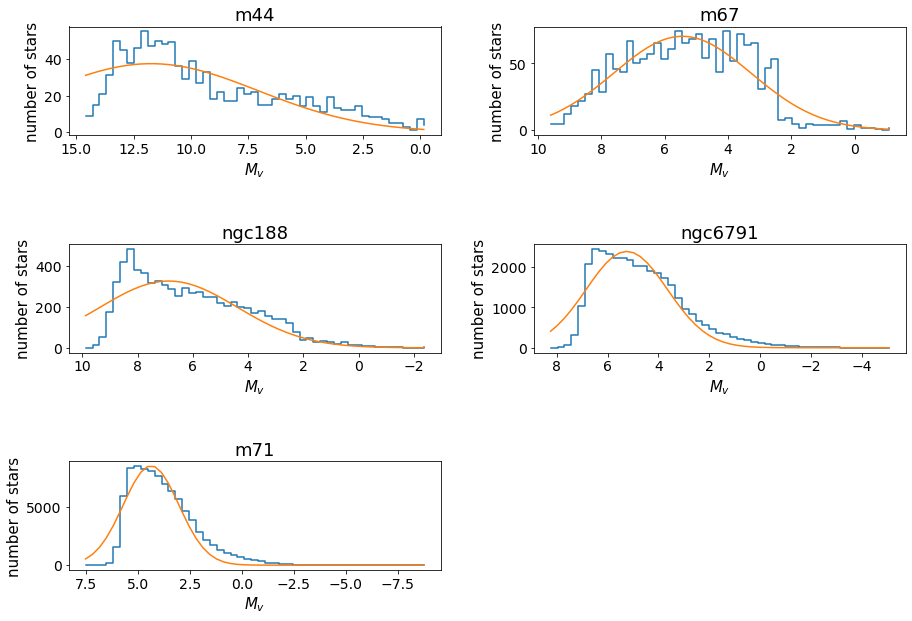

In [148]:
# 12a. Construct Mv-band luminosity function for each cluster using a generalized histogram 
def plot_luminosity_function(data, tag, ax):
    hist, bins = np.histogram(data.Mv_cluster.dropna(), bins=50)
    
    # Gaussian fit
    popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=hist, p0=[1,1,1])
    fit = gauss(bins[:-1], *popt)
    
    # Plot
    ax.step(bins[:-1], hist)
    ax.plot(bins[:-1], fit)
    ax.set_ylabel('number of stars', fontsize=15)
    ax.set_xlabel(r'$M_v$', fontsize=15)
    ax.set_title(tag, fontsize=18)
    ax.set_xlim(ax.get_xlim()[::-1]) # invert y-axis so brightest is top

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return
    
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for tag in range(len(tags)):
    ax = axes[tag]
    plot_luminosity_function(keep_parallaxes.loc[keep_parallaxes.tag==tags[tag]], tags[tag], ax)
    
fig.delaxes(axes[5]) 
fig.savefig('luminosity_function.png')
plt.show()

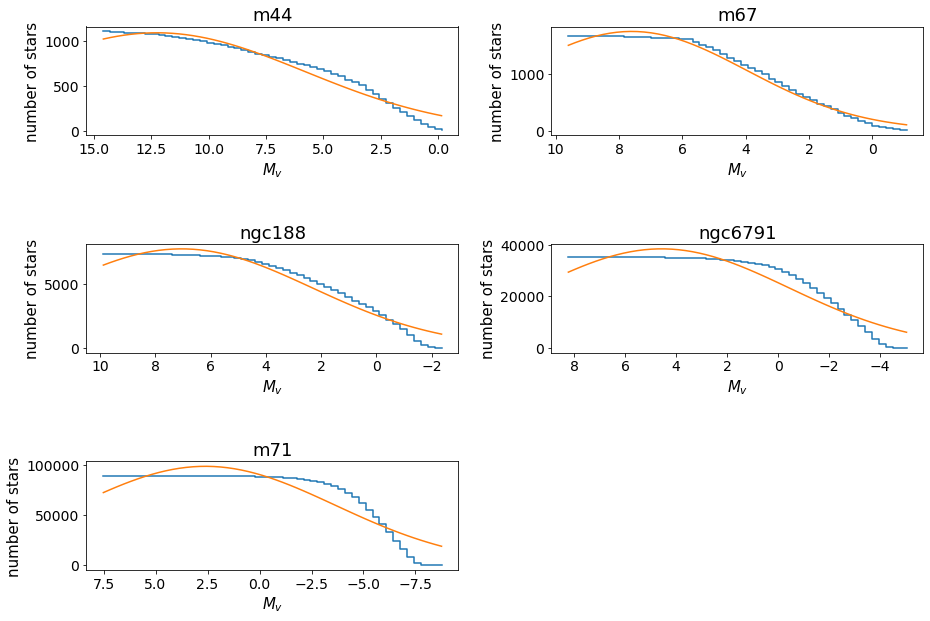

In [149]:
# 12b. Same but with cumulative histogram
def plot_cumulative_luminosity_function(data, tag, ax):
    hist, bins = np.histogram(data.Mv_cluster.dropna(), bins=50)
    
    # Gaussian fit
    popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=np.cumsum(hist[::-1]), p0=[1,1,1])
    fit = gauss(bins[:-1], *popt)
    
    # Plot
    #ax.step(bins[:-1], hist)
    # cumulative sum; invert order b/c they count from highest bin
    ax.step(bins[:-1], np.cumsum(hist[::-1]))
    ax.plot(bins[:-1], fit)
    ax.set_ylabel('number of stars', fontsize=15)
    ax.set_xlabel(r'$M_v$', fontsize=15)
    ax.set_title(tag, fontsize=18)
    ax.set_xlim(ax.get_xlim()[::-1]) # invert y-axis so brightest is top

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return
    
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for tag in range(len(tags)):
    ax = axes[tag]
    plot_cumulative_luminosity_function(keep_parallaxes.loc[keep_parallaxes.tag==tags[tag]], tags[tag], ax)
    
fig.delaxes(axes[5]) 
fig.savefig('cumulative_luminosity_function.png')
plt.show()

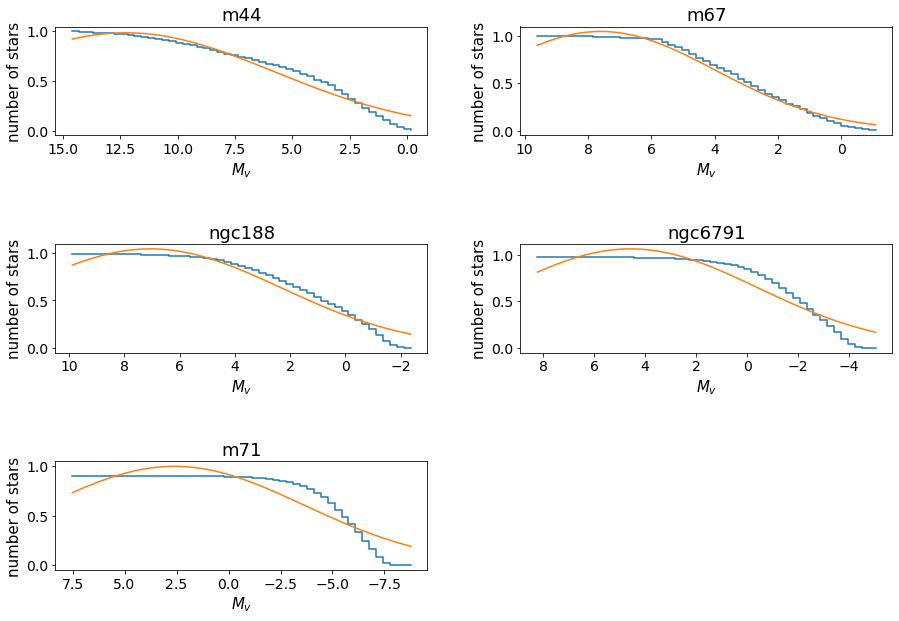

In [150]:
# 13a. Normalize cumulative luminosity functions
def plot_normalized_cumulative_luminosity_function(data, tag, ax):
    hist, bins = np.histogram(data.Mv_cluster.dropna(), bins=50)
    
    # Gaussian fit
    popt, pcov = curve_fit(gauss, xdata=bins[:-1], ydata=np.cumsum(hist[::-1])/len(data), p0=[1,1,1])
    fit = gauss(bins[:-1], *popt)
    
    # Plot
    #ax.step(bins[:-1], hist)
    # cumulative sum; invert order b/c they count from highest bin
    ax.step(bins[:-1], np.cumsum(hist[::-1])/len(data))
    ax.plot(bins[:-1], fit)
    ax.set_ylabel('number of stars', fontsize=15)
    ax.set_xlabel(r'$M_v$', fontsize=15)
    ax.set_title(tag, fontsize=18)
    ax.set_xlim(ax.get_xlim()[::-1]) # invert y-axis so brightest is top

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    
    return
    
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15,10))
fig.subplots_adjust(wspace=0.25, hspace=1.0)
axes = axes.flatten()
for tag in range(len(tags)):
    ax = axes[tag]
    plot_normalized_cumulative_luminosity_function(keep_parallaxes.loc[keep_parallaxes.tag==tags[tag]], tags[tag], ax)
    
fig.delaxes(axes[5]) 
fig.savefig('normalized_cumulative_luminosity_function.png')
plt.show()

In [ ]:
# 13b. Compare with ages/metallicity from literature
# M44: 625±50Myrs: Dobbie et al 2006; https://arxiv.org/pdf/astro-ph/0603314.pdf
# M67: 4 Gyrs: Richer et al 1998; https://arxiv.org/pdf/astro-ph/9806172.pdf
# NGC 188: 6.2 ± 0.2 Gyr: Meibom et al 2009; https://iopscience.iop.org/article/10.1088/0004-6256/137/6/5086
# NGC 6791: 7.2 - 9.5 Gyrs depending on isochrones: Grundahl et al 2008; https://arxiv.org/pdf/0810.2407.pdf
# M71: 12 +/- 2 Gyr: Di Cecco et al 2015, https://arxiv.org/pdf/1506.01180.pdf

# See write-up...but basically young clusters correspond dimmer luminosity functions